In [16]:
import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

import keijzer_exogan as ke

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab

# Initialize default seaborn layout
sns.set_palette(sns.hls_palette(8, l=.3, s=.8))
sns.set(style='ticks') 

In [17]:
df = pd.read_csv('Validation error of 300 images')
df.head()

,Unnamed: 0,planet_mass_error,temp_profile_error,ch4_mixratio_error,planet_radius_error,h2o_mixratio_error,co2_mixratio_error,co_mixratio_error,planet_mass_real,temp_profile_real,...,h2o_mixratio_real,co2_mixratio_real,co_mixratio_real,planet_mass_inpainted,temp_profile_inpainted,ch4_mixratio_inpainted,planet_radius_inpainted,h2o_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted
0,0,5.661163,31.361074,-2.327390,4.737051,24.952615,62.101305,26.327365,2.783733e+27,1111.111112,...,-11.257083,-2.302585,-7.675284,2.941325e+27,1459.567487,-5.747431,8.135858e+07,-14.066019,-3.732520,-9.695984
1,0,-13.048820,-4.089689,-18.805864,-12.189896,12.601827,-7.587653,213.024861,3.542933e+27,1666.666687,...,-7.675284,-18.420681,-2.302585,3.080622e+27,1598.505199,-4.777775,8.730869e+07,-8.642510,-17.022983,-7.207663
2,0,78.932011,-7.405640,-11.204942,5.870980,-10.245773,-10.385621,-17.940168,1.518400e+27,1666.666687,...,-14.838882,-13.047982,-13.047982,2.716904e+27,1543.239355,-8.405503,8.223940e+07,-13.318524,-11.692868,-10.707152
3,0,0.201200,12.775918,-10.427065,2.849062,-3.088335,-12.340510,-26.639497,2.783733e+27,1333.333343,...,-5.884384,-7.675284,-14.838882,2.789334e+27,1503.678918,-6.874977,8.548445e+07,-5.702654,-6.728115,-10.885878
4,0,-20.523508,53.794920,-10.669709,-7.284073,-0.112408,2.501071,146.518672,3.542933e+27,1000.000000,...,-5.884384,-16.629781,-4.093484,2.815799e+27,1537.949204,-14.855432,8.210360e+07,-5.877769,-17.045704,-10.091203


In [18]:
df.describe()

,Unnamed: 0,planet_mass_error,temp_profile_error,ch4_mixratio_error,planet_radius_error,h2o_mixratio_error,co2_mixratio_error,co_mixratio_error,planet_mass_real,temp_profile_real,...,h2o_mixratio_real,co2_mixratio_real,co_mixratio_real,planet_mass_inpainted,temp_profile_inpainted,ch4_mixratio_inpainted,planet_radius_inpainted,h2o_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted
count,299.0,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,2.990000e+02,299.000000,...,299.000000,299.000000,299.000000,2.990000e+02,299.000000,299.000000,2.990000e+02,299.000000,299.000000,299.000000
mean,0.0,15.713422,5.895516,5.340291,9.065622,16.242172,8.564769,44.946664,2.672012e+27,1520.995921,...,-10.035198,-10.753954,-10.472441,2.840518e+27,1539.090907,-10.319700,8.350403e+07,-10.037147,-10.754715,-9.981728
std,0.0,35.242684,23.907377,28.527681,20.059364,40.747182,29.029305,115.904347,7.460256e+26,312.953531,...,5.359477,4.903923,5.344182,1.167563e+26,70.019800,4.499224,2.814984e+06,4.158729,4.208165,1.237916
min,0.0,-30.863006,-29.398108,-37.968818,-19.468898,-45.547231,-29.644180,-60.973078,1.518400e+27,1000.000000,...,-18.420681,-18.420681,-18.420681,2.483743e+27,1390.344650,-18.946603,7.636269e+07,-18.670960,-18.252468,-12.090480
25%,0.0,-13.255513,-14.327465,-11.078034,-7.641582,-8.667321,-7.610574,-33.741196,2.024533e+27,1222.222224,...,-14.838882,-14.838882,-14.838882,2.759840e+27,1486.579120,-14.047381,8.134933e+07,-13.552876,-14.460260,-10.881487
50%,0.0,4.940959,1.186970,-3.135292,4.667664,2.551014,0.331295,-6.448407,2.783733e+27,1555.555582,...,-9.466183,-11.257083,-11.257083,2.833612e+27,1524.859905,-10.459735,8.332425e+07,-9.864541,-10.216314,-10.167876
75%,0.0,41.357334,21.641297,11.209554,24.730897,28.035599,13.385505,78.235741,3.289867e+27,1777.777791,...,-5.884384,-7.675284,-5.884384,2.920773e+27,1590.746462,-5.891893,8.564393e+07,-6.180877,-7.293353,-9.185581
max,0.0,98.688519,67.424035,123.908460,50.851026,157.668662,146.995854,399.970290,3.796000e+27,2000.000000,...,-2.302585,-2.302585,-2.302585,3.119902e+27,1738.314986,-3.638888,9.060250e+07,-3.960854,-3.358731,-5.163591


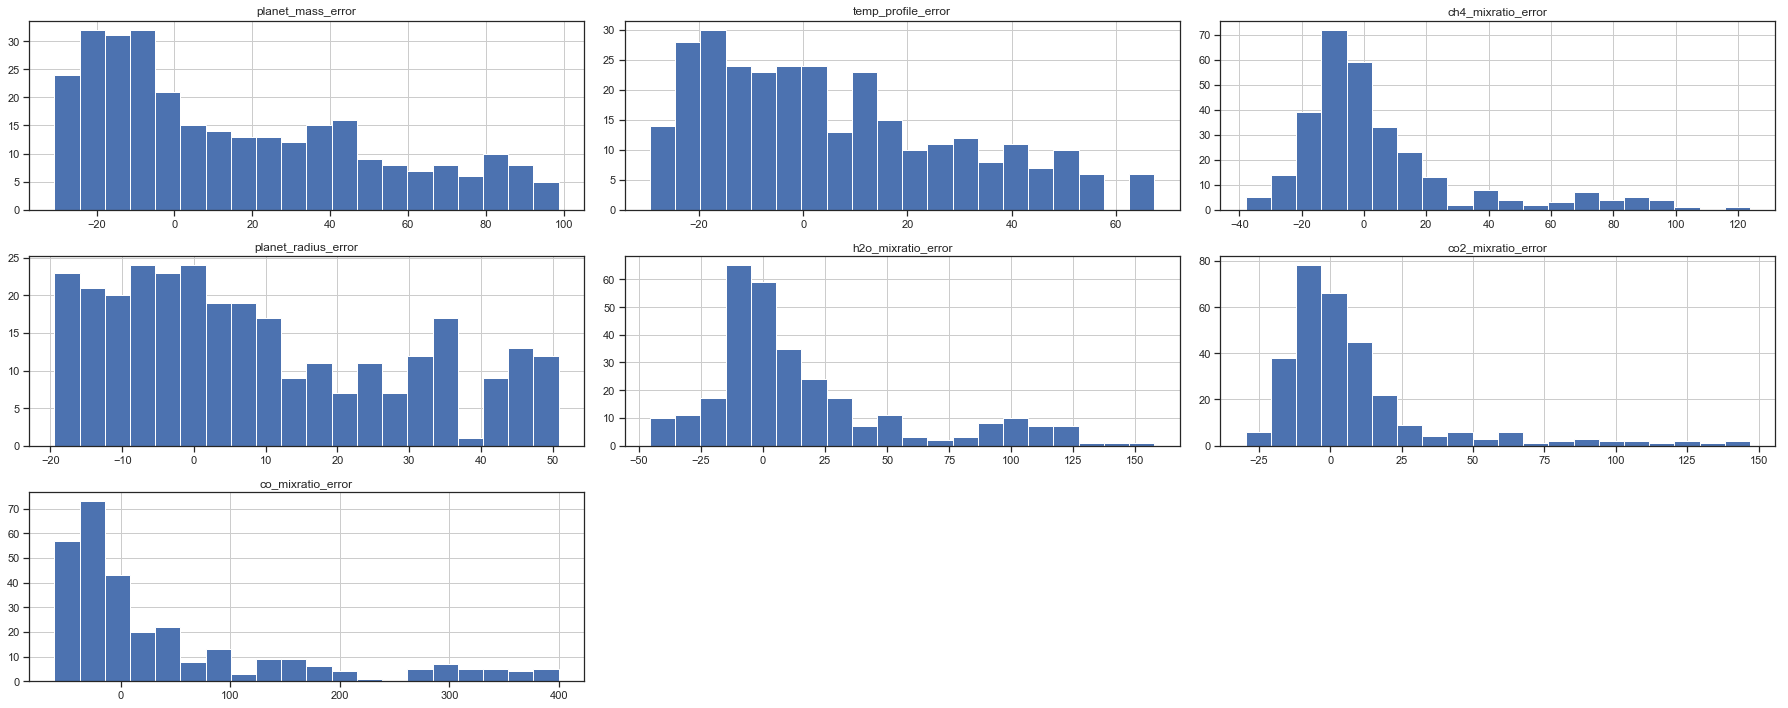

In [19]:
params = ['planet_mass','temp_profile','ch4_mixratio','planet_radius','h2o_mixratio','co2_mixratio','co_mixratio']

plt.figure(figsize=((25,10)))
for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.title(param+'_error')
    plt.hist(df[param+'_error'], bins=20)
    plt.grid()
    plt.tight_layout()

# Grab the $n$ sigma errors

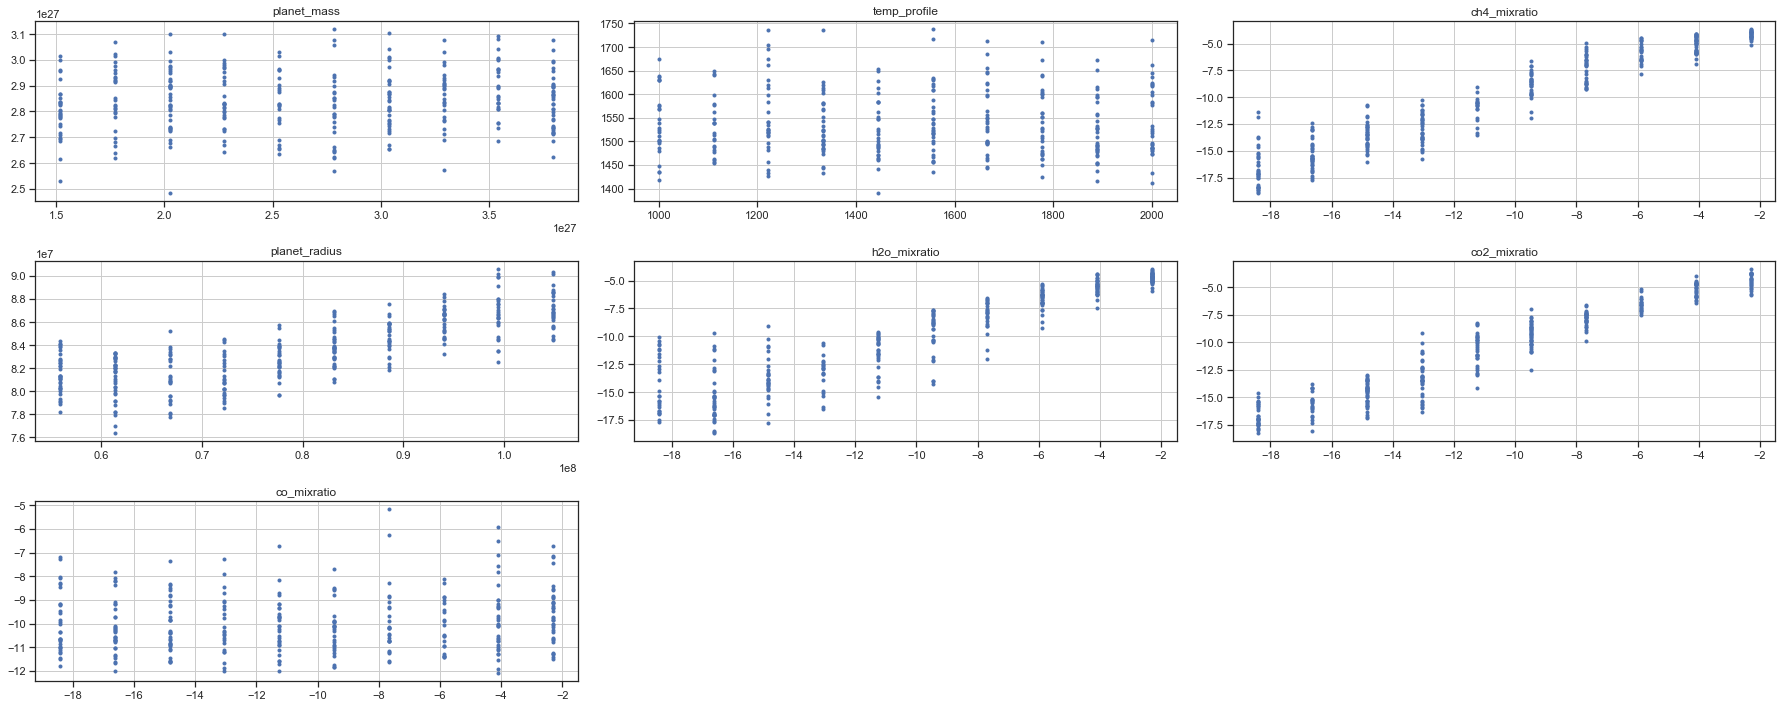

In [20]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.title(param)
    plt.plot(df[param+'_real'], df[param+'_inpainted'], '.')
    plt.grid()
    plt.tight_layout()